In [241]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

In [242]:
data_dir = "./data"
symbol = "BNBUSDT"
start_date = "2025-08-11"
end_date = "2025-09-10"
interval = "1m"
funding_file_name = f"{symbol}_{start_date}_{end_date}.csv"
file_name = f"{symbol}_{start_date}_{end_date}_{interval}.csv"

In [243]:
# 资金费率数据目录
binance_funding_data_dir = os.path.join(data_dir, "binance", "funding_rate")
bybit_funding_data_dir = os.path.join(data_dir, "bybit", "funding_rate")
# 价格数据目录
binance_price_data_dir = os.path.join(data_dir, "binance", "price")
bybit_price_data_dir = os.path.join(data_dir, "bybit", "price")
# 价格指数数据目录
binance_index_data_dir = os.path.join(data_dir, "binance", "price_index")
bybit_index_data_dir = os.path.join(data_dir, "bybit", "price_index")
# 溢价指数数据目录
binance_premium_data_dir = os.path.join(data_dir, "binance", "premium_index")
bybit_premium_data_dir = os.path.join(data_dir, "bybit", "premium_index")

In [244]:
# 读取资金费率数据
binance_funding_data_df = pd.read_csv(os.path.join(binance_funding_data_dir, funding_file_name))
bybit_funding_data_df = pd.read_csv(os.path.join(bybit_funding_data_dir, funding_file_name))
# 读取价格数据
binance_price_data_df = pd.read_csv(os.path.join(binance_price_data_dir, file_name))
bybit_price_data_df = pd.read_csv(os.path.join(bybit_price_data_dir, file_name))
# 读取价格指数数据
binance_index_data_df = pd.read_csv(os.path.join(binance_index_data_dir, file_name))
bybit_index_data_df = pd.read_csv(os.path.join(bybit_index_data_dir, file_name))
# 读取溢价指数数据
binance_premium_data_df = pd.read_csv(os.path.join(binance_premium_data_dir, file_name))
bybit_premium_data_df = pd.read_csv(os.path.join(bybit_premium_data_dir, file_name))

In [245]:
# 对于funding文件，需要的列有：fundingTime, fundingRate
# 对于price文件，需要的列有：open_time, close并将close列重命名为price
# 对于index_price文件，需要的列有：open_time, close并将close列重命名为index_price
# 对于premium_index文件，需要的列有：open_time, close并将close列重命名为premium_index
binance_funding_data_df = binance_funding_data_df[["fundingTime", "fundingRate"]]
bybit_funding_data_df = bybit_funding_data_df[["fundingTime", "fundingRate"]]
binance_price_data_df = binance_price_data_df[["open_time", "close"]].rename(columns={"close": "price"})
bybit_price_data_df = bybit_price_data_df[["open_time", "close"]].rename(columns={"close": "price"})
binance_index_data_df = binance_index_data_df[["open_time", "close"]].rename(columns={"close": "index_price"})
bybit_index_data_df = bybit_index_data_df[["open_time", "close"]].rename(columns={"close": "index_price"})
binance_premium_data_df = binance_premium_data_df[["open_time", "close"]].rename(columns={"close": "premium_index"})
bybit_premium_data_df = bybit_premium_data_df[["open_time", "close"]].rename(columns={"close": "premium_index"})

### 绘制计算持有的funding收益
1. 计算funding_profit，使用公式：funding_profit = - binance_funding + bybit_funding
2. 计算funding_profit的累计收益
3. 绘制funding_profit的累计收益曲线

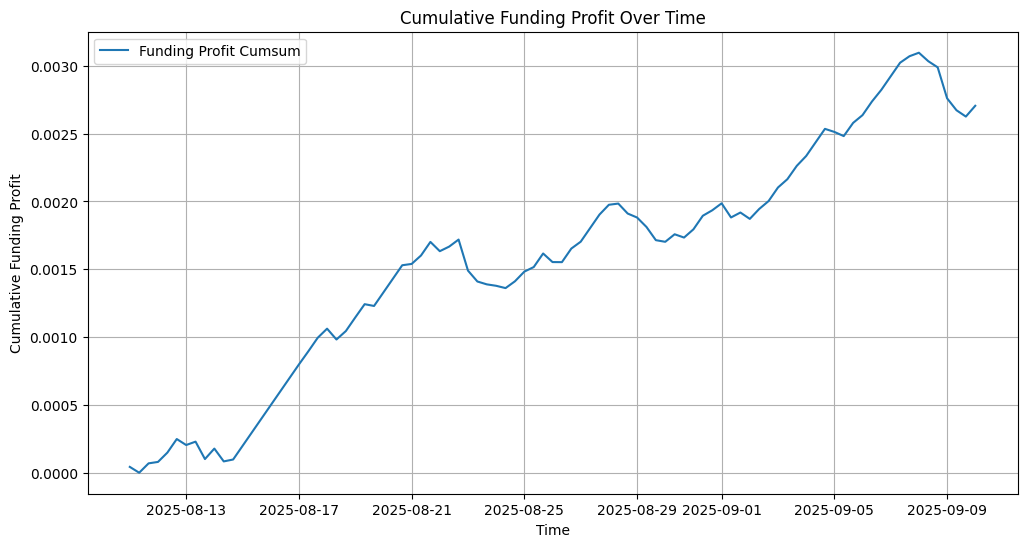

In [246]:
# 按 fundingTime 合并两个交易所的资金费率数据
funding_df = binance_funding_data_df.merge(
  bybit_funding_data_df, on="fundingTime", suffixes=("_binance", "_bybit")
)

# 计算 funding_profit
funding_df["funding_profit"] = -funding_df["fundingRate_binance"] + funding_df["fundingRate_bybit"]
# 计算 funding_profit 的累计收益
funding_df["funding_profit_cumsum"] = funding_df["funding_profit"].cumsum()
# 将 fundingTime 转换为 datetime 格式
if funding_df["fundingTime"].dtype == np.int64 or funding_df["fundingTime"].dtype == np.float64:
  funding_df["fundingTime"] = pd.to_datetime(funding_df["fundingTime"], unit="ms")
elif funding_df["fundingTime"].dtype == object:
  funding_df["fundingTime"] = pd.to_datetime(funding_df["fundingTime"])
# 绘制 funding_profit 的累计收益曲线
plt.figure(figsize=(12, 6))
plt.plot(funding_df["fundingTime"], funding_df["funding_profit_cumsum"], label="Funding Profit Cumsum")
plt.xlabel("Time")
plt.ylabel("Cumulative Funding Profit")
plt.title("Cumulative Funding Profit Over Time")
plt.legend()
plt.grid()
plt.show()

In [247]:
# 合并文件
# 先将价格，指数，溢价指数文件按open_time合并
binance_merged_df = binance_price_data_df.merge(binance_index_data_df, on="open_time").merge(binance_premium_data_df, on="open_time")
# 先将open_time转换为datetime类型，并按时间排序
binance_merged_df["open_time"] = pd.to_datetime(binance_merged_df["open_time"], unit='ms')
binance_merged_df = binance_merged_df.sort_values("open_time")
# 合并资金费率文件
binance_funding_data_df["fundingTime"] = pd.to_datetime(binance_funding_data_df["fundingTime"])
binance_merged_df = binance_merged_df.merge(binance_funding_data_df, left_on="open_time", right_on="fundingTime", how="left")
# 将fundingTime与fundingRate列向上移动1行
binance_merged_df["fundingTime"] = binance_merged_df["fundingTime"].shift(-1)
binance_merged_df["fundingRate"] = binance_merged_df["fundingRate"].shift(-1)
# 使用下一行的fundingTime与fundingRate填充当前行的NaN值，向后填充
binance_merged_df["fundingTime"] = binance_merged_df["fundingTime"].bfill()
binance_merged_df["fundingRate"] = binance_merged_df["fundingRate"].bfill()
print(binance_merged_df.tail())


                open_time   price  index_price  premium_index fundingTime  \
43196 2025-09-09 23:56:00  880.31   879.964023       0.000376  2025-09-10   
43197 2025-09-09 23:57:00  880.32   879.995702       0.000358  2025-09-10   
43198 2025-09-09 23:58:00  880.32   880.021508       0.000323  2025-09-10   
43199 2025-09-09 23:59:00  880.30   879.959966       0.000306  2025-09-10   
43200 2025-09-10 00:00:00  880.60   880.231509       0.000401         NaT   

       fundingRate  
43196          0.0  
43197          0.0  
43198          0.0  
43199          0.0  
43200          NaN  


In [248]:
bybit_merged_df = bybit_price_data_df.merge(bybit_index_data_df, on="open_time").merge(bybit_premium_data_df, on="open_time")
# 先将open_time转换为datetime类型，并按时间排序
bybit_merged_df["open_time"] = pd.to_datetime(bybit_merged_df["open_time"], unit='ms')
bybit_merged_df = bybit_merged_df.sort_values("open_time")
# 合并资金费率文件
bybit_funding_data_df["fundingTime"] = pd.to_datetime(bybit_funding_data_df["fundingTime"])
bybit_merged_df = bybit_merged_df.merge(bybit_funding_data_df, left_on="open_time", right_on="fundingTime", how="left")
# 将fundingTime与fundingRate列向上移动1行
bybit_merged_df["fundingTime"] = bybit_merged_df["fundingTime"].shift(-1)
bybit_merged_df["fundingRate"] = bybit_merged_df["fundingRate"].shift(-1)
# 使用下一行的fundingTime与fundingRate填充当前行的NaN值，向后填充
bybit_merged_df["fundingTime"] = bybit_merged_df["fundingTime"].bfill()
bybit_merged_df["fundingRate"] = bybit_merged_df["fundingRate"].bfill()
print(bybit_merged_df.tail())

                open_time  price  index_price  premium_index fundingTime  \
43196 2025-09-09 23:56:00  879.4       879.94      -0.000761  2025-09-10   
43197 2025-09-09 23:57:00  879.4       879.98      -0.000561  2025-09-10   
43198 2025-09-09 23:58:00  879.4       879.99      -0.000496  2025-09-10   
43199 2025-09-09 23:59:00  879.5       879.98      -0.000493  2025-09-10   
43200 2025-09-10 00:00:00  879.6       880.22      -0.000458         NaT   

       fundingRate  
43196      0.00008  
43197      0.00008  
43198      0.00008  
43199      0.00008  
43200          NaN  


In [249]:
# 使用open_time合并两个交易所的数据
merged_df = binance_merged_df.merge(bybit_merged_df, on="open_time", suffixes=("_binance", "_bybit"))
# 删除nan值
merged_df = merged_df.dropna()
# 重置索引
merged_df = merged_df.reset_index(drop=True)